In [1]:
# import packages
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['axes.linewidth'] = 2

plt.rc('xtick',labelsize = 20)
plt.rc('ytick',labelsize = 20)
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['legend.fontsize'] = 25


In [2]:
# import the data
bikes = pd.read_csv('train.csv', index_col=0, parse_dates=True)
bikes.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [3]:
# In order to include the correlations from timestamp I will introduce new columns:
bikes['hour'] = bikes.index.hour
bikes['day'] = bikes.index.day
bikes['month'] = bikes.index.month
bikes['year'] = bikes.index.year
bikes['year_span'] = bikes['month']+(bikes['year']-2011)*12
bikes.insert(15, 'count', bikes.pop('count'))
bikes.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,hour,day,month,year,year_span,count
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,0,1,1,2011,1,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,1,1,1,2011,1,40


# 2. Exploratory Data Analysis + Feature Engineering

# Separate notebook was created for the expolration of the data.
- bike_EDA

# Make the pipeline

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import Lasso 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import os
print(os.getcwd())

/Users/alexandros.samartzis/Spiced_Academy/stationary-sriracha-student-code/week_3/spiced_porojects


In [5]:
bikes.drop(['temp','registered','casual'],axis=1,inplace=True)
bikes.head(2)

,season,holiday,workingday,weather,atemp,humidity,windspeed,hour,day,month,year,year_span,count
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,14.395,81,0.0,0,1,1,2011,1,16
2011-01-01 01:00:00,1,0,0,1,13.635,80,0.0,1,1,1,2011,1,40


In [6]:
# split to X, and y
X = bikes.iloc[:,:12]
y = bikes['count']# feature engineering for numericals
X.head(1)

,season,holiday,workingday,weather,atemp,humidity,windspeed,hour,day,month,year,year_span
datetime,,,,,,,,,,,,
2011-01-01,1,0,0,1,14.395,81,0.0,0,1,1,2011,1


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42) 

In [ ]:
y_train.hist()
y_train.tail(1)

# Transform the Count variable: 
### We use a logarithmic transformation to optimize the target's distribution. Idealy a normal distribution for linear models.

* In this way we also make sure we do not predict negative counts

In [8]:
ylog_train = np.log1p(y_train)
ylog_test = np.log1p(y_test)

<AxesSubplot:>

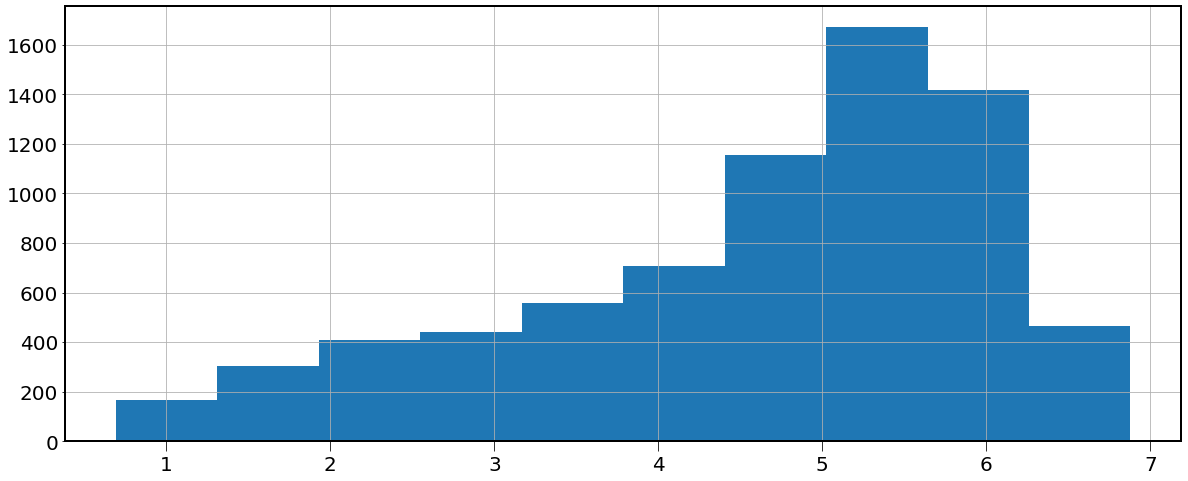

In [9]:
ylog_train.hist()

- Data transformations
- -  Make the pipelines

In [ ]:
# feature engineering for numericals
categorical_features = ["hour"]
# create a sequential pipeline 
# output of one step will be input to the next 
categorical_transformer_cf = make_pipeline(
    OneHotEncoder(sparse=False, handle_unknown='ignore')
    )

In [ ]:
# feature engineering for numericals
numeric_features = ["windspeed", "humidity","atemp"]

# create a sequential pipeline 
# output of one step will be input to the next 
numeric_transformer_nf = make_pipeline(
    PolynomialFeatures(degree= 3, include_bias= False,interaction_only=True),
    StandardScaler()
    )

In [ ]:
# feature engineering for numericals
time_features = ["month", "day","hour","year"]

# create a sequential pipeline 
# output of one step will be input to the next 
time_transformer_tf = make_pipeline(
    PolynomialFeatures(degree= 3, include_bias= False,interaction_only=True),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
    )

In [ ]:
# feature engineering for numericals
workday_feature = ["workingday"]

# create a sequential pipeline 
# output of one step will be input to the next 
workday_transformer_tf = make_pipeline(
    OneHotEncoder(sparse=False, handle_unknown='ignore')
    )

In [ ]:

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_nf, numeric_features),
        ("cat", categorical_transformer_cf, categorical_features),
        ('time', time_transformer_tf, time_features),
        ('work', workday_transformer_tf, ["workingday"]),
    ],
    remainder='passthrough')


In [ ]:
# create the model pipeline
pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=300))

# split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state= 42)

####
# fit the pipeline to training data
pipeline.fit(X_train, y_train)
###


In [ ]:
# calculate the accuracy score from test data
print("model score: %.3f" % pipeline.score(X_test, y_test))

# get predictions from the pipeline
print(pipeline.predict(X_test))

In [ ]:
accuracy_score(y_validation,ypred) 